In [15]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [16]:
def add_labels(graph_title, x_label, y_label):
    """Add labels to graphs"""
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

## Constitutive model

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

## Parameters

In [17]:
E_accurate = 210  # Young's modulus (GPa)
yield_stress = 0.25  # Yield stress (GPa)
s_noise = 0.01  # Noise in the stress measurement (GPa)


The parameters to be identified for the linear elastic-perfectly plastic model are the Young's modulus and the initial yield stress, which are stored in the parameter vector $\textbf{x}=[E \; \sigma_{y0}]^T$

## Mean stress-strain graph

In [22]:
def build_mean_stress(E_accurate, yield_stress, strain):
    
    stress[0] = 0
    
    for i in range(len(strain)):
        if stress[i] < yield_stress:
            stress[i] = E_accurate * strain[i]
        elif stress[i] > yield_stress:
            stress[i] = yield_stress
   
    return stress

In [23]:
strain = numpy.linspace(0, 2.5E-3)
stress = build_mean_stress(E_accurate, yield_stress, strain)

## Likelihood

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

In [ ]:
mean_vector = numpy.array([[200], [0.29]])  # Mean vector (GPa)
cov_matrix = numpy.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)


## Posterior

$$\pi(\textbf{x}|\textbf{y}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$


In [ ]:
def calculate_posterior():
    pass

## Experimental data

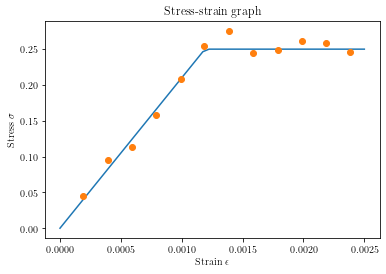

In [25]:
strain_measured = [0.191E-3, 0.397E-3, 0.595E-3, 0.792E-3, 0.990E-3, 1.187E-3, 
                   1.392E-3, 1.587E-3, 1.789E-3, 1.985E-3, 2.184E-3, 2.383E-3]
stress_measured = [0.0448, 0.0955, 0.113, 0.158, 0.209, 0.255, 
                   0.276, 0.244, 0.249, 0.262, 0.259, 0.246]

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

## Markov Chain Monte Carlo

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$